In [1]:
import pandas as pd
import numpy as np
import os
import time
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("✅ 1. Necessary libraries imported.")

✅ 1. Necessary libraries imported.


In [2]:
# --- Configuration ---
# Use a relative path for the data file
DATA_FILE = "Input_data_RF.csv"
MODEL_OUTPUT_PATH = "random_forest_model_best.pkl"
TIME_LAGS = 5  # Number of past time steps to use as features

# Mapping for the multi-class state (used for feature generation)
STATE_NUMERIC_MAPPING = {
    "arrival": 0,
    "stay": 1,
    "leave": 2,
    "outside": 3
}

# Mapping for the final binary target (in/out)
STATE_BINARY_MAPPING = {
    "arrival": 1,  # in
    "stay": 1,     # in
    "leave": 0,    # out
    "outside": 0   # out
}

# --- Load Data ---
try:
    input_data = pd.read_csv(DATA_FILE)
    print(f"✅ 2. Successfully loaded data from {DATA_FILE}")
    print(f"   - Initial data shape: {input_data.shape}")
    print("Data preview:")
    print(input_data.head())

except FileNotFoundError:
    print(f"❌ Error: Data file not found at {DATA_FILE}")
    print("Please make sure the file is in the same directory as this notebook.")
    # In a notebook, we avoid exit(), but we can set a flag
    data_loaded = False
else:
    data_loaded = True

✅ 2. Successfully loaded data from Input_data_RF.csv
   - Initial data shape: (668, 1)
Data preview:
     state
0  outside
1  outside
2  outside
3  outside
4  outside


In [3]:
if data_loaded:
    # Step 1: Map states to numeric values for feature generation
    input_data['state_numeric'] = input_data['state'].map(STATE_NUMERIC_MAPPING)
    print("Mapped 'state' to 'state_numeric'.")
    
    # Step 2: Map states to the final binary target (in/out)
    input_data['state_binary'] = input_data['state'].map(STATE_BINARY_MAPPING)
    print("Mapped 'state' to 'state_binary' (target).")

    # Step 3: Generate time-lag features based on numeric state
    print(f"Generating {TIME_LAGS} time-lag features (t-1 to t-{TIME_LAGS})...")
    for lag in range(1, TIME_LAGS + 1):
        input_data[f't-{lag}'] = input_data['state_numeric'].shift(lag)

    # Step 4: Drop rows with NaN values (created by the shift/lag)
    rows_before_drop = len(input_data)
    preprocessed_data = input_data.dropna()
    rows_after_drop = len(preprocessed_data)
    print(f"Dropped {rows_before_drop - rows_after_drop} rows containing NaN values.")

    # Step 5: Define feature set (X) and target (y)
    features = [f't-{lag}' for lag in range(1, TIME_LAGS + 1)]
    target = 'state_binary'

    X = preprocessed_data[features]
    y = preprocessed_data[target]

    print("\n✅ 3. Feature engineering complete.")
    print(f"   - Features (X) shape: {X.shape}")
    print(f"   - Target (y) shape: {y.shape}")
else:
    print("❌ 3. Skipping feature engineering because data was not loaded.")

Mapped 'state' to 'state_numeric'.
Mapped 'state' to 'state_binary' (target).
Generating 5 time-lag features (t-1 to t-5)...
Dropped 5 rows containing NaN values.

✅ 3. Feature engineering complete.
   - Features (X) shape: (663, 5)
   - Target (y) shape: (663,)


In [4]:
if data_loaded and 'X' in locals():
    # Split the data into training and testing sets
    # 'stratify=y' ensures both train and test sets have a similar proportion of in/out classes
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42, 
        stratify=y
    )
    
    print("✅ 4. Data split into training and testing sets.")
    print(f"   - X_train shape: {X_train.shape}")
    print(f"   - y_train shape: {y_train.shape}")
    print(f"   - X_test shape:  {X_test.shape}")
    print(f"   - y_test shape:  {y_test.shape}")
else:
    print("❌ 4. Skipping train/test split because data was not processed.")

✅ 4. Data split into training and testing sets.
   - X_train shape: (530, 5)
   - y_train shape: (530,)
   - X_test shape:  (133, 5)
   - y_test shape:  (133,)


In [5]:
# --- Define Parameter Grid for Grid Search ---
param_grid = {
    'n_estimators': [50, 100, 150],       # Number of trees in the forest
    'max_depth': [10, 20, 30],            # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],      # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],        # Minimum samples required at a leaf node
    'class_weight': ['balanced'],         # Use balanced class weights
}

# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
# 'cv=5' means 5-fold cross-validation
# 'n_jobs=-1' uses all available CPU cores
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='accuracy',  # Use accuracy as the evaluation metric
    cv=5,                # Number of cross-validation folds
    verbose=2,           # Print progress messages
    n_jobs=-1            # Use all available CPU cores
)

print("✅ 5. Random Forest model and GridSearchCV defined.")
total_fits = (
    len(param_grid['n_estimators']) *
    len(param_grid['max_depth']) *
    len(param_grid['min_samples_split']) *
    len(param_grid['min_samples_leaf']) *
    5 # 5 folds
)
print(f"   - GridSearchCV will run {total_fits} total fits.")

✅ 5. Random Forest model and GridSearchCV defined.
   - GridSearchCV will run 405 total fits.


In [6]:
if 'X_train' in locals():
    print("Starting GridSearchCV for hyperparameter tuning...")
    print("This may take a few minutes...")
    start_time = time.time()
    
    # Run the grid search
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    print(f"\nTraining complete in {end_time - start_time:.2f} seconds.")

    # --- Show GridSearch Results ---
    print("\n--- GridSearchCV Results ---")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validation Score (Accuracy): {grid_search.best_score_:.4f}")
    
    print("\n✅ 6. Model training and grid search complete.")
else:
    print("❌ 6. Training skipped because data was not split.")

Starting GridSearchCV for hyperparameter tuning...
This may take a few minutes...
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Training complete in 10.92 seconds.

--- GridSearchCV Results ---
Best Parameters: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best Cross-Validation Score (Accuracy): 0.9094

✅ 6. Model training and grid search complete.


In [7]:
if 'grid_search' in locals():
    print("Evaluating the best model on the test set...")
    
    # Get the best model found by the grid search
    best_rf_model = grid_search.best_estimator_
    
    # Make predictions on the test set
    y_pred = best_rf_model.predict(X_test)

    # --- Calculate Evaluation Metrics ---
    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred, target_names=['out (0)', 'in (1)'])

    # --- Display Evaluation Results ---
    print("\n--- Model Evaluation Results (Test Set) ---")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"\nConfusion Matrix: \n{conf_matrix}")
    print(f"\nClassification Report: \n{class_report}")
    
    print("\n✅ 7. Model evaluation complete.")
else:
    print("❌ 7. Evaluation skipped because the model was not trained.")

Evaluating the best model on the test set...

--- Model Evaluation Results (Test Set) ---
Accuracy: 0.9398

Confusion Matrix: 
[[46  6]
 [ 2 79]]

Classification Report: 
              precision    recall  f1-score   support

     out (0)       0.96      0.88      0.92        52
      in (1)       0.93      0.98      0.95        81

    accuracy                           0.94       133
   macro avg       0.94      0.93      0.94       133
weighted avg       0.94      0.94      0.94       133


✅ 7. Model evaluation complete.


Generating confusion matrix plot...


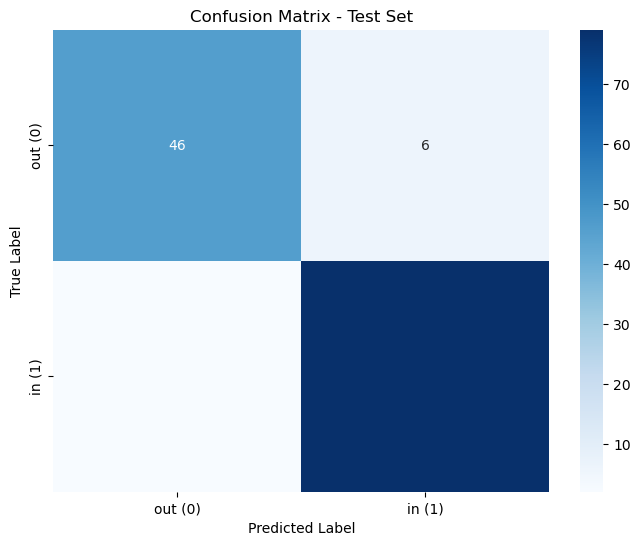


✅ 8. Confusion matrix plot generated.


In [8]:
# This cell provides a visual representation of the confusion matrix
if 'conf_matrix' in locals():
    print("Generating confusion matrix plot...")
    
    # Define class labels for the plot
    class_labels = ['out (0)', 'in (1)']

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, 
        annot=True,     # Show numbers inside the cells
        fmt='d',        # Format as integers
        cmap='Blues',   # Color map
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix - Test Set')
    plt.show()
    
    print("\n✅ 8. Confusion matrix plot generated.")
else:
    print("❌ 8. Plotting skipped because the confusion matrix was not calculated.")

In [9]:
if 'grid_search' in locals():
    # Save the best model (best_estimator_) found by Grid Search
    joblib.dump(grid_search.best_estimator_, MODEL_OUTPUT_PATH)
    
    print(f"Best model saved to: {MODEL_OUTPUT_PATH}")
    print("\n✅ 9. Final model saved to disk.")
else:
    print("❌ 9. Model saving skipped because the model was not trained.")

Best model saved to: random_forest_model_best.pkl

✅ 9. Final model saved to disk.
